In [ ]:
import os
import time
import random
import pandas as pd
import csv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import librosa
import librosa.display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls ./drive/MyDrive/ESC-50-master/

Mounted at /content/drive
audio	   LICENSE  mfccs	README.md	  tests
esc50.gif  meta     pytest.ini	requirements.txt  waveforms


In [ ]:
dataset = pd.read_csv('./drive/MyDrive/ESC-50-master/meta/esc50.csv')
LB = LabelBinarizer().fit(dataset.target)
# checkpoint
LB.transform([next(dataset.iterrows())[1]['target']])[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and testing sets
for train_index, val_index in sss.split(dataset, dataset.target):
    train_df = dataset.iloc[train_index]
    val_df = dataset.iloc[val_index]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_index, test_index in sss.split(val_df, val_df.target):
    val_df = dataset.iloc[val_index]
    test_df = dataset.iloc[test_index]

print("Size of the training set : ", train_df.shape )
print("Size of the validation set : ", val_df.shape )
print("Size of the testing set : ", test_df.shape )

train_df = train_df[['filename','target']]
val_df = val_df[['filename','target']]
test_df = test_df[['filename','target']]


Size of the training set :  (1600, 7)
Size of the validation set :  (200, 7)
Size of the testing set :  (200, 7)


### Load waveforms and pre-compute the spectrograms

In [ ]:
# create the output directories if it doesn't exist
for output_dir in ['./waveforms', './mfccs']:
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

In [ ]:
wav_len_arr_check = []
#wav_mono_arr_check = []
sr_arr_check = []
top_db = 80
n_fft = 1024
hop_len = 512
n_mels = 128
for sample in dataset.iterrows():
  path = './drive/MyDrive/ESC-50-master/audio/' + sample[1]['filename']
  waveform, sampling_rate = librosa.load(path)
  #wav_mono_arr_check.append(waveform.shape[0])
  wav_len_arr_check.append(waveform.shape[0])
  sr_arr_check.append(sampling_rate)
  np.save(f"./waveforms/{sample[1]['filename'][:-4]}", waveform)
  # compute MFCCs
  mfccs_features = librosa.feature.mfcc(y=waveform, sr=sampling_rate, n_mfcc=40) 
  np.save(f"./mfccs/{sample[1]['filename'][:-4]}.npy", mfccs_features)
  

In [ ]:
# run this to copy data from drive to colab
#!cp -r ./drive/MyDrive/ESC-50-master/waveforms ./ 
!cp -r ./drive/MyDrive/ESC-50-master/mfccs ./

### Check if all samples have equal size and sampling rate

In [ ]:
size = len(wav_len_arr_check)
assert size == 2000 # ESC-50 dataset
assert wav_len_arr_check.count(110250) == size and sr_arr_check.count(22050) == size
print('All samples have a length of 110250 corresponding to a length of 5 seconds and sampling rate of 22050.')

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):   
    """ Keras Sequence class for generating audio data: raw, mel
    Args:
        df: dataframe, it should contain the path and target of the 
            training, test or validation data
        data_type: the type of data we want to use in the process: raw data,
                   mel spectrograms and so on
        transforms: transforms applied in data augmentation
        augment_prob: the probability we use for augmentation, e.g. if 0.5 then
                      50% of the dataset will be randomly augmented during each
                      epoch
    """
    def __init__(self, df, data_type='mfcc', batch_size=50, transforms=augmentation_2d, augment_prob=0.5, aug_par=[1,1,0.04],
                  shuffle=True):
        self.df = df
        self.data_type = data_type
        self.transforms = transforms
        self.augment_prob = augment_prob
        self.aug_par = aug_par
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.num_classes = 50
        #self.data_path = './drive/MyDrive/ESC-50-master/audio/'
        self.data = []
        data_folder = 'mfccs' if self.data_type == 'mfcc' else 'waveforms'
        self.dim = (110250,) if data_type=='raw' else (40,216)
        for sample in df.iterrows():
            filepath = f"./{data_folder}/{sample[1]['filename'][:-4]}.npy"
            target = sample[1]['target']
            self.data.append([filepath, target])
        self.shuffle_indexes()

    def shuffle_indexes(self):
        """method to shuffle the indexes for each epoch"""
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
          np.random.shuffle(self.indexes)

    def __getitem__(self, index): 
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = np.empty((self.batch_size, *self.dim, 1))
        y = np.empty((self.batch_size, self.num_classes))
        for i, idx in enumerate(indexes):
          path = self.data[idx][0]
          target = self.data[idx][1]
          sp = np.load(path)

          if self.transforms and np.random.rand(1) < self.augment_prob:
              sp = self.transforms(sp, max_mask=0.1, n_freq=self.aug_par[0], n_time=self.aug_par[1], noise_level=self.aug_par[2])   
          
          X[i,] = np.expand_dims(sp, axis=-1)
          y[i] = LB.transform([target])[0]

          
        #target_onehot = torch.from_numpy(LB.transform([target])[0]).float()
        X = tf.convert_to_tensor(X, dtype=tf.float32) 
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        
        #tf.convert_to_tensor(y, dtype=tf.int64) 
        return X, y




    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

### CNN

In [ ]:
def ResBlock2D(F, padding="same", maxpool=False):
    layer = tf.keras.Sequential()
    if maxpool:
        layer.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding=padding))
    layer.add(tf.keras.layers.Conv2D(F, (3, 3), padding=padding))
    layer.add(tf.keras.layers.BatchNormalization())
    layer.add(tf.keras.layers.Activation('relu'))
    layer.add(tf.keras.layers.Conv2D(F, (3, 3), padding=padding))
    layer.add(tf.keras.layers.BatchNormalization())
    return layer

def Identity(F):
    identity = tf.keras.Sequential()
    identity.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    identity.add(tf.keras.layers.Conv2D(F*2, (1, 1), strides=(1,1), padding='same', activation=None))
    identity.add(tf.keras.layers.BatchNormalization(axis=-1))
    return identity

In [ ]:
def ConvPool2D(F, padding='valid', pooling_padding='valid', maxpool=True):
    layer = tf.keras.Sequential()
    layer.add(tf.keras.layers.Conv2D(F, (3, 3), strides=(1,1), padding=padding, activation=None))
    #layer.add(tf.keras.layers.BatchNormalization(axis=-1))
    layer.add(tf.keras.layers.Activation('relu'))
    if maxpool:
      layer.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding=pooling_padding))
    return layer

In [ ]:

class CNN(tf.keras.Model):
    def __init__(self, F=32, n=2, num_classes=50, p_dropout=None, residual=False):
        super().__init__()
        self.F = F
        self.n = n
        self.p_dropout = p_dropout
        self.residual = residual

        Layer = ResBlock2D if residual else ConvPool2D

        activation = 'relu'
        self.description = f'CNN_{n}layers'
        hidden_units = 150

        if residual:
          self.identity_1 = Identity(F)
          if n > 2:
            self.identity_2 = Identity(F)
          

        # 1st block
        self.layer_1 = ConvPool2D(F)

        self.layer_2 = Layer(F*2, maxpool=True)
        if n > 2:
          if residual: hidden_units = 500
          self.layer_3 = Layer(F*2, maxpool=True)
        if n > 3:
          hidden_units = 450
          self.layer_4 = Layer(F*2, maxpool=False)
          
        if n > 4:
          self.layer_5 = Layer(F*2, maxpool=False, padding="same")
        if n > 5:
          self.layer_6 = Layer(F*2, maxpool=False, padding="same")
        k = 10 if n == 2 else 5
        self.pool_gru = tf.keras.layers.MaxPool2D((k, 1), strides=(k, 1), padding='same')
        #self.gru = tf.keras.layers.GRU(F*2, name='gru0')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.fc2 = tf.keras.layers.Dense(num_classes, activation=None)
        
        if p_dropout:
          self.dropout = tf.keras.layers.Dropout(p_dropout)

   
        
    def call(self, X):
     
        # apply ConvPool2D layers (Conv2D -> BN -> ReLU -> MaxPooling2D)

        X = self.layer_1(X)
        Xr = self.layer_2(X)
        X = Xr + self.identity_1(X) if self.residual else Xr
        #print(X.shape)
        if self.n > 2:
          Xr = self.layer_3(X)
          #print(Xr.shape)
          X = Xr + self.identity_2(X) if self.residual else Xr

        #print(X.shape)
        if self.n > 3:
          Xr = self.layer_4(X)
          X = Xr + X if self.residual else Xr
        if self.n > 4:
          Xr = self.layer_5(X)
          X = Xr + X if self.residual else Xr
        if self.n > 5:
          Xr = self.layer_6(X)
          X = Xr + X if self.residual else Xr
        
        #print(X.shape)
        # flatten
  
        X = self.pool_gru(X)
        #X = tf.keras.backend.squeeze(X, axis=1)
        #X = self.gru(X)
        X = self.flatten(X)
        # print(X.shape)
        # dense layers
        X = self.fc1(X)
        X = self.fc2(X)
        # dropout  
        if self.p_dropout:
          X = self.dropout(X)
        return X

### SoundNet Architecture

In [ ]:
"""conv1  pool1 conv2 pool2 conv3 pool3 conv4 conv5

#f     32   32   64   64   128   128  256   1401
f-size  64  8    32   8    16    8     8     16
stride  2   8     2   8    2     8     2     12
padding 32  0    16   0    8     0     4      4
dim   220,050 27,506 13,782 1,722 862 432 217 54"""

class SoundNet(tf.keras.Model):
    """
    SoundNet model implementation of 5 layers version.
    More info here: http://soundnet.csail.mit.edu/
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in TensorFlow
    """
    def __init__(self, F=32, num_classes=50, p_dropout=None):
        super().__init__()
        self.F = F
        self.p_dropout = p_dropout
        activation = 'relu'
        # 1st block
        self.block_1 =  tf.keras.Sequential()
        self.block_1.add(tf.keras.layers.Conv1D(F, F*2, strides=2, padding='same', activation=None))
        self.block_1.add(tf.keras.layers.BatchNormalization(axis=-1))
        self.block_1.add(tf.keras.layers.Activation(activation))
        self.block_1.add(tf.keras.layers.MaxPooling1D(8, 8, padding='valid'))
        
        self.block_2 =  tf.keras.Sequential()
        self.block_2.add(tf.keras.layers.Conv1D(F*2, F, strides=2, padding='same', activation=None))
        self.block_2.add(tf.keras.layers.BatchNormalization(axis=-1))
        self.block_2.add(tf.keras.layers.Activation(activation))
        self.block_2.add(tf.keras.layers.MaxPooling1D(8, 8, padding='valid'))
        
        self.block_3 =  tf.keras.Sequential()
        self.block_3.add(tf.keras.layers.Conv1D(F*4, F//2, strides=2, padding='same', activation=None))
        self.block_3.add(tf.keras.layers.BatchNormalization(axis=-1))
        self.block_3.add(tf.keras.layers.Activation(activation))
        self.block_3.add(tf.keras.layers.MaxPooling1D(8, 8, padding='valid'))
        
        self.conv_4 = tf.keras.layers.Conv1D(256, 8, strides=2, padding='same', activation=None)
        self.conv_5 = tf.keras.layers.Conv1D(1401, 16, strides=12, padding='same')
        #self.fc = tf.keras.Sequential()
        #self.fc.add(tf.keras.layers.Dense(10, activation=activation))
        self.fc = tf.keras.layers.Dense(num_classes, activation=None)
        
        if p_dropout:
          self.dropout = tf.keras.layers.Dropout(p_dropout)

    def call(self, X):

        # the first three conv-pool blocks (Conv1D -> BN -> ReLU -> MaxPooling1D)
        X = self.block_1(X)
        X = self.block_2(X)
        X = self.block_3(X)
        
        # fourth and fifth conv layers
        X = self.conv_4(X)
        X = self.conv_5(X)

        # flatten the tensor and output layer + dropout
        X = tf.keras.layers.Flatten()(X)
        X = self.fc(X)
        if self.p_dropout:
          X = self.dropout(X)

        return X

### Augmentation

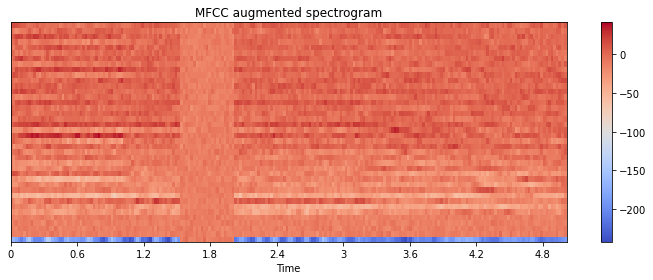

In [ ]:
def augmentation_2d(spec, max_mask=0.1, n_freq=1, n_time=1, noise_level=0.10):
    n_mels, n_steps = spec.shape
    mask_value = np.mean(spec)
    aug_spec = spec

    freq_mask_param = int(max_mask * n_mels)
    for _ in range(n_freq):
        freq_start = np.random.randint(0, n_mels - freq_mask_param)
        aug_spec[freq_start: freq_start + freq_mask_param, :] = mask_value

    time_mask_param = int(max_mask * n_steps)
    for _ in range(n_time):
        time_start = np.random.randint(0, n_steps - time_mask_param)
        aug_spec[:, time_start: time_start + time_mask_param] = mask_value

    if noise_level > 0.0:
        noise = np.random.randn(*spec.shape)
        noise_level = noise_level * np.max(spec)
        aug_spec += noise_level * noise

    return aug_spec
X = np.load(f"./mfccs/1-100038-A-14.npy")
X.shape

plt.figure(figsize=(10, 4))
librosa.display.specshow(augmentation_2d(X), x_axis='time')
plt.colorbar()
plt.title('MFCC augmented spectrogram')
plt.tight_layout()
plt.show()

### Define model and hyperparameters

In [ ]:
# Parameters
params = {'data_type': 'mfcc',
          'batch_size': 50,
          'epochs': 50,
          'augment_prob': 0.4,
          'p_dropout': 0.5,
          'optimizer_name': 'Adam',
          'lr': 0.0001}

transforms = augmentation_2d

# Generators
training_generator = DataGenerator(train_df, data_type=params["data_type"], batch_size=params["batch_size"], transforms=transforms, augment_prob=0.5, aug_par=[1,1,0.02], shuffle=True)
validation_generator = DataGenerator(val_df, data_type=params["data_type"], batch_size=params["batch_size"], transforms=None, augment_prob=0., shuffle=True)
testing_generator = DataGenerator(test_df, data_type=params["data_type"], batch_size=params["batch_size"], transforms=None, augment_prob=0., shuffle=True)

X, y = next(iter(training_generator))
F = 128
residual = False
model = CNN(p_dropout=params['p_dropout'],F=F,n=2,residual=residual)
y1 = model(X)
model.summary()
total_params = model.count_params()

timestamp = time.strftime("feb%d_t%H%M", time.gmtime())
model_name = f"{model.description}_{params['batch_size']}_E{params['epochs']}_O{params['optimizer_name']}_LR{params['lr']}_pD{params['p_dropout']}_A{params['augment_prob']}_{timestamp}"

Model: "cnn_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (50, 19, 107, 128)        1280      
                                                                 
 sequential_21 (Sequential)  (50, 8, 52, 256)          295168    
                                                                 
 max_pooling2d_32 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        multiple                  0         
                                                                 
 dense_20 (Dense)            multiple                  665650    
                                                                 
 dropout_10 (Dropout)        multiple                  0         
                                                            

### Training function

In [ ]:
def train_model(network_model, train_generator, val_generator, learning_rate=params['lr'], num_epochs=params['epochs'], verbose=True):
    """
    Arguments:
    network_model -- the keras Sequential model to be trained
    train_generator -- DataGenerator object providing the training samples
    val_generator -- DataGenerator object providing the validation samples
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    verbose -- printing boolean
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    validation_accuracy -- real number, testing accuracy on the validation set (X_val)
    """
    
    tf.random.set_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)                                 
    costs = []                                        # To keep track of the cost
    val_costs = []

    optimizer = tf.keras.optimizers.Adam(learning_rate)

    cost_function = lambda x,y: tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred= x, y_true = y, from_logits=True))
    best_val_cost = float('inf') # initialize the best validation cost

    t0 = time.time()
    avg_t = 0
    num_minibatches = len(train_generator) # number of minibatches of size minibatch_size in the train set
    for epoch in range(num_epochs):
        minibatch_cost = 0.
        val_cost = 0.
        train_accuracy = 0.
        val_accuracy = 0.

        
        seed += 1

        for X, y in train_generator:
            with tf.GradientTape() as tape:

                # Forward propagation
                outp = network_model(X)
  
                # Cost function
                cost = cost_function(outp, y)
    
            # backpropagation
            gradients = tape.gradient(cost, network_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, network_model.trainable_variables))

            minibatch_cost += cost / num_minibatches
            # Calculate accuracy 
            train_accuracy += tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outp, 1), tf.argmax(y, 1)), "float"))/num_minibatches
            
        for X, y in val_generator:
            outp = network_model(X, training=False)
            val_accuracy += tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outp, 1), tf.argmax(y, 1)), "float")) / len(val_generator)
            val_cost += cost_function(outp, y) / len(val_generator)
            
        # Print the cost and accuracy every epoch
        if verbose:
            t = ((10 * (time.time() - t0)) // 6) / 100
            avg_t += t
            print ("[%f min, epoch %i] Train Cost: %f --- Validation Cost: %f --- Train accuracy: %f --- Validation accuracy: %f" % (t, epoch + 1, minibatch_cost, val_cost, train_accuracy, val_accuracy))   
        if val_cost < best_val_cost:
            best_val_cost = val_cost
            best_val_acc = val_accuracy
            best_tr_acc = train_accuracy
            best_epoch = epoch + 1
            network_model.save_weights(f"./drive/MyDrive/HDA_results/{model_name}.h5")
        costs.append(minibatch_cost)
        val_costs.append(val_cost)

    # plot the cost
    plt.plot(np.squeeze(costs[4:]), label='training cost')
    plt.plot(np.squeeze(val_costs[4:]), label="validation cost")
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.title(model_name)
    plt.legend()
    plt.savefig(f'./drive/MyDrive/HDA_results/{model_name}.png')
    plt.show()
    return best_val_acc, best_tr_acc, best_epoch, avg_t/num_epochs

def test_model(network_model, test_generator):
      cost_function = lambda x,y: tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred= x, y_true = y, from_logits=True))
      test_accuracy = 0.
      test_cost = 0.
      for X, y in test_generator:
          outp = network_model(X, training=False)
          test_accuracy += tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outp, 1), tf.argmax(y, 1)), "float")) / len(test_generator)
          test_cost += cost_function(outp, y) / len(test_generator)
      print ("[TESTING] Test accuracy: %f --- Test cost: %f" % (test_accuracy, test_cost))  
      return test_accuracy, test_cost

In [ ]:
best_val_accuracy, best_train_accuracy, best_epoch, t = train_model(model, training_generator, validation_generator)
model.load_weights(f"./drive/MyDrive/HDA_results/{model_name}.h5")
test_accuracy, test_cost = test_model(model, testing_generator)

# save the training hyperparameters and results info 
current_time = time.strftime("%m-%d %H:%M")
with open('./drive/MyDrive/HDA_results/HDA_log.csv', mode='a') as file:
    writer = csv.writer(file)
    writer.writerow([current_time, model.description, params['data_type'], 
                     params['batch_size'], params['epochs'], 
                     params['augment_prob'], params['p_dropout'],
                     params['optimizer_name'], params['lr'], 
                     np.round(best_train_accuracy, 4), 
                     np.round(best_val_accuracy, 4), 
                     np.round(test_accuracy, 4), best_epoch, total_params, F, residual, t])

[0.120000 min, epoch 1] Train Cost: 10.399149 --- Validation Cost: 3.695009 --- Train accuracy: 0.058750 --- Validation accuracy: 0.100000
[0.180000 min, epoch 2] Train Cost: 3.130069 --- Validation Cost: 2.581231 --- Train accuracy: 0.206875 --- Validation accuracy: 0.300000
[0.230000 min, epoch 3] Train Cost: 2.416356 --- Validation Cost: 2.128856 --- Train accuracy: 0.336875 --- Validation accuracy: 0.425000
[0.290000 min, epoch 4] Train Cost: 1.940865 --- Validation Cost: 1.704538 --- Train accuracy: 0.465625 --- Validation accuracy: 0.550000
[0.360000 min, epoch 5] Train Cost: 1.564417 --- Validation Cost: 1.476675 --- Train accuracy: 0.570625 --- Validation accuracy: 0.585000
[0.420000 min, epoch 6] Train Cost: 1.277169 --- Validation Cost: 1.282472 --- Train accuracy: 0.639375 --- Validation accuracy: 0.615000
[0.470000 min, epoch 7] Train Cost: 1.017674 --- Validation Cost: 1.132357 --- Train accuracy: 0.710000 --- Validation accuracy: 0.670000
[0.530000 min, epoch 8] Train Cos

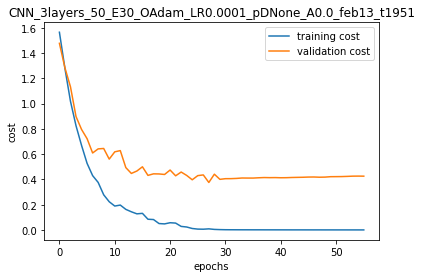

[TESTING] Test accuracy: 0.905000 --- Test cost: 0.360096
[0.110000 min, epoch 1] Train Cost: 9.084195 --- Validation Cost: 3.586641 --- Train accuracy: 0.061250 --- Validation accuracy: 0.145000
[0.170000 min, epoch 2] Train Cost: 3.206631 --- Validation Cost: 2.744575 --- Train accuracy: 0.198125 --- Validation accuracy: 0.245000
[0.240000 min, epoch 3] Train Cost: 2.488463 --- Validation Cost: 2.282774 --- Train accuracy: 0.338750 --- Validation accuracy: 0.370000
[0.290000 min, epoch 4] Train Cost: 2.033244 --- Validation Cost: 1.906897 --- Train accuracy: 0.448750 --- Validation accuracy: 0.470000
[0.350000 min, epoch 5] Train Cost: 1.668417 --- Validation Cost: 1.671263 --- Train accuracy: 0.543125 --- Validation accuracy: 0.530000
[0.410000 min, epoch 6] Train Cost: 1.433821 --- Validation Cost: 1.410376 --- Train accuracy: 0.605000 --- Validation accuracy: 0.610000
[0.480000 min, epoch 7] Train Cost: 1.184947 --- Validation Cost: 1.202435 --- Train accuracy: 0.667500 --- Valida

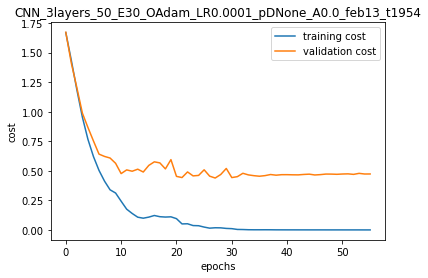

[TESTING] Test accuracy: 0.900000 --- Test cost: 0.416737
[0.120000 min, epoch 1] Train Cost: 11.843390 --- Validation Cost: 4.362291 --- Train accuracy: 0.065000 --- Validation accuracy: 0.085000
[0.190000 min, epoch 2] Train Cost: 3.566138 --- Validation Cost: 3.040188 --- Train accuracy: 0.144375 --- Validation accuracy: 0.230000
[0.250000 min, epoch 3] Train Cost: 2.705071 --- Validation Cost: 2.332049 --- Train accuracy: 0.278750 --- Validation accuracy: 0.370000
[0.310000 min, epoch 4] Train Cost: 2.243364 --- Validation Cost: 2.018872 --- Train accuracy: 0.378750 --- Validation accuracy: 0.430000
[0.380000 min, epoch 5] Train Cost: 1.891905 --- Validation Cost: 1.848405 --- Train accuracy: 0.471250 --- Validation accuracy: 0.470000
[0.440000 min, epoch 6] Train Cost: 1.596382 --- Validation Cost: 1.525693 --- Train accuracy: 0.548750 --- Validation accuracy: 0.525000
[0.490000 min, epoch 7] Train Cost: 1.361855 --- Validation Cost: 1.314171 --- Train accuracy: 0.613750 --- Valid

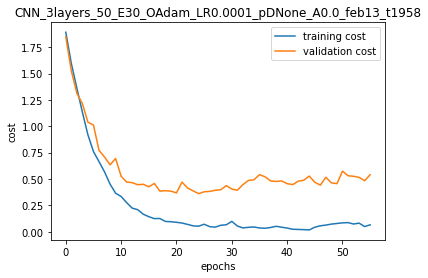

[TESTING] Test accuracy: 0.905000 --- Test cost: 0.493499
[0.130000 min, epoch 1] Train Cost: 10.043404 --- Validation Cost: 3.918048 --- Train accuracy: 0.059375 --- Validation accuracy: 0.085000
[0.190000 min, epoch 2] Train Cost: 3.336751 --- Validation Cost: 2.723690 --- Train accuracy: 0.175000 --- Validation accuracy: 0.290000
[0.240000 min, epoch 3] Train Cost: 2.582166 --- Validation Cost: 2.243267 --- Train accuracy: 0.307500 --- Validation accuracy: 0.380000
[0.320000 min, epoch 4] Train Cost: 2.176976 --- Validation Cost: 1.860787 --- Train accuracy: 0.404375 --- Validation accuracy: 0.460000
[0.370000 min, epoch 5] Train Cost: 1.817312 --- Validation Cost: 1.620899 --- Train accuracy: 0.475625 --- Validation accuracy: 0.555000
[0.420000 min, epoch 6] Train Cost: 1.549632 --- Validation Cost: 1.380760 --- Train accuracy: 0.566875 --- Validation accuracy: 0.620000
[0.480000 min, epoch 7] Train Cost: 1.258128 --- Validation Cost: 1.132887 --- Train accuracy: 0.638125 --- Valid

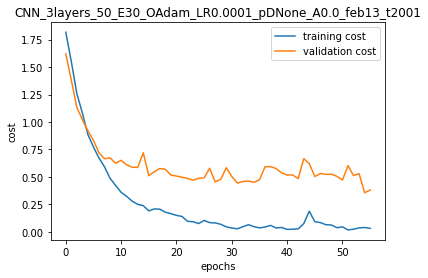

[TESTING] Test accuracy: 0.905000 --- Test cost: 0.473402
[0.110000 min, epoch 1] Train Cost: 11.529613 --- Validation Cost: 4.013802 --- Train accuracy: 0.050000 --- Validation accuracy: 0.140000
[0.180000 min, epoch 2] Train Cost: 3.367122 --- Validation Cost: 2.649868 --- Train accuracy: 0.173125 --- Validation accuracy: 0.300000
[0.240000 min, epoch 3] Train Cost: 2.569031 --- Validation Cost: 2.203984 --- Train accuracy: 0.312500 --- Validation accuracy: 0.370000
[0.290000 min, epoch 4] Train Cost: 2.105688 --- Validation Cost: 1.939307 --- Train accuracy: 0.414375 --- Validation accuracy: 0.435000
[0.350000 min, epoch 5] Train Cost: 1.778483 --- Validation Cost: 1.697902 --- Train accuracy: 0.503125 --- Validation accuracy: 0.505000
[0.420000 min, epoch 6] Train Cost: 1.548039 --- Validation Cost: 1.424287 --- Train accuracy: 0.563125 --- Validation accuracy: 0.560000
[0.470000 min, epoch 7] Train Cost: 1.276978 --- Validation Cost: 1.210861 --- Train accuracy: 0.651250 --- Valid

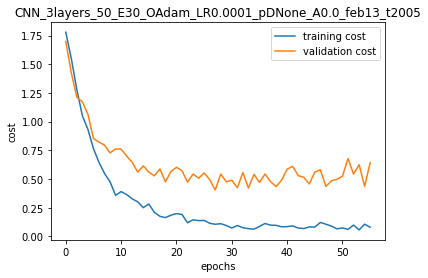

[TESTING] Test accuracy: 0.870000 --- Test cost: 0.511243
[0.110000 min, epoch 1] Train Cost: 12.009038 --- Validation Cost: 4.667050 --- Train accuracy: 0.053125 --- Validation accuracy: 0.100000
[0.180000 min, epoch 2] Train Cost: 3.659309 --- Validation Cost: 2.959626 --- Train accuracy: 0.149375 --- Validation accuracy: 0.235000
[0.230000 min, epoch 3] Train Cost: 2.780222 --- Validation Cost: 2.393918 --- Train accuracy: 0.281250 --- Validation accuracy: 0.320000
[0.280000 min, epoch 4] Train Cost: 2.324581 --- Validation Cost: 1.983555 --- Train accuracy: 0.373125 --- Validation accuracy: 0.430000
[0.340000 min, epoch 5] Train Cost: 1.967065 --- Validation Cost: 1.741640 --- Train accuracy: 0.477500 --- Validation accuracy: 0.505000
[0.410000 min, epoch 6] Train Cost: 1.680656 --- Validation Cost: 1.610858 --- Train accuracy: 0.538750 --- Validation accuracy: 0.515000
[0.460000 min, epoch 7] Train Cost: 1.448032 --- Validation Cost: 1.286298 --- Train accuracy: 0.605000 --- Valid

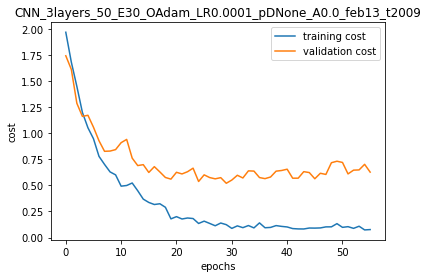

[TESTING] Test accuracy: 0.890000 --- Test cost: 0.551644
[0.120000 min, epoch 1] Train Cost: 9.660745 --- Validation Cost: 3.906959 --- Train accuracy: 0.043750 --- Validation accuracy: 0.145000
[0.180000 min, epoch 2] Train Cost: 3.417588 --- Validation Cost: 2.707848 --- Train accuracy: 0.163125 --- Validation accuracy: 0.275000
[0.230000 min, epoch 3] Train Cost: 2.717711 --- Validation Cost: 2.304643 --- Train accuracy: 0.276875 --- Validation accuracy: 0.335000
[0.280000 min, epoch 4] Train Cost: 2.326897 --- Validation Cost: 2.033120 --- Train accuracy: 0.371875 --- Validation accuracy: 0.360000
[0.360000 min, epoch 5] Train Cost: 1.922349 --- Validation Cost: 1.730493 --- Train accuracy: 0.475000 --- Validation accuracy: 0.480000
[0.410000 min, epoch 6] Train Cost: 1.650218 --- Validation Cost: 1.428669 --- Train accuracy: 0.540000 --- Validation accuracy: 0.590000
[0.460000 min, epoch 7] Train Cost: 1.457857 --- Validation Cost: 1.256781 --- Train accuracy: 0.598750 --- Valida

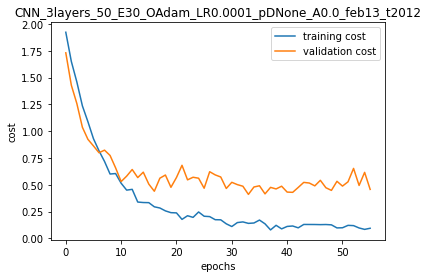

[TESTING] Test accuracy: 0.900000 --- Test cost: 0.389833
[0.120000 min, epoch 1] Train Cost: 9.780938 --- Validation Cost: 3.849677 --- Train accuracy: 0.058750 --- Validation accuracy: 0.095000
[0.180000 min, epoch 2] Train Cost: 3.514751 --- Validation Cost: 2.697505 --- Train accuracy: 0.143750 --- Validation accuracy: 0.240000
[0.230000 min, epoch 3] Train Cost: 2.771538 --- Validation Cost: 2.294708 --- Train accuracy: 0.278125 --- Validation accuracy: 0.365000
[0.280000 min, epoch 4] Train Cost: 2.342264 --- Validation Cost: 2.041274 --- Train accuracy: 0.383750 --- Validation accuracy: 0.410000
[0.350000 min, epoch 5] Train Cost: 2.069082 --- Validation Cost: 1.754485 --- Train accuracy: 0.440000 --- Validation accuracy: 0.495000
[0.410000 min, epoch 6] Train Cost: 1.766315 --- Validation Cost: 1.482552 --- Train accuracy: 0.512500 --- Validation accuracy: 0.560000
[0.460000 min, epoch 7] Train Cost: 1.511465 --- Validation Cost: 1.315734 --- Train accuracy: 0.579375 --- Valida

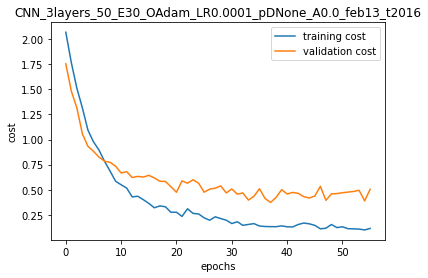

[TESTING] Test accuracy: 0.880000 --- Test cost: 0.534762
[0.110000 min, epoch 1] Train Cost: 11.185556 --- Validation Cost: 3.526820 --- Train accuracy: 0.068125 --- Validation accuracy: 0.125000
[0.180000 min, epoch 2] Train Cost: 3.165326 --- Validation Cost: 2.591691 --- Train accuracy: 0.211875 --- Validation accuracy: 0.295000
[0.230000 min, epoch 3] Train Cost: 2.347125 --- Validation Cost: 2.083970 --- Train accuracy: 0.362500 --- Validation accuracy: 0.425000
[0.280000 min, epoch 4] Train Cost: 1.871104 --- Validation Cost: 1.760223 --- Train accuracy: 0.478750 --- Validation accuracy: 0.500000
[0.340000 min, epoch 5] Train Cost: 1.502849 --- Validation Cost: 1.434619 --- Train accuracy: 0.577500 --- Validation accuracy: 0.575000
[0.410000 min, epoch 6] Train Cost: 1.218503 --- Validation Cost: 1.258726 --- Train accuracy: 0.658125 --- Validation accuracy: 0.660000
[0.460000 min, epoch 7] Train Cost: 0.965439 --- Validation Cost: 1.107475 --- Train accuracy: 0.735000 --- Valid

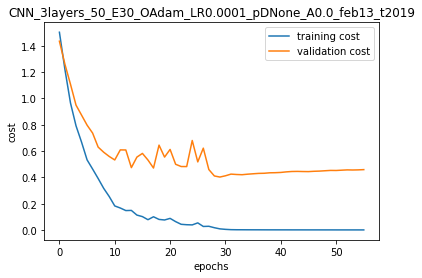

[TESTING] Test accuracy: 0.910000 --- Test cost: 0.344990
[0.110000 min, epoch 1] Train Cost: 9.934930 --- Validation Cost: 3.735026 --- Train accuracy: 0.065000 --- Validation accuracy: 0.135000
[0.180000 min, epoch 2] Train Cost: 3.169203 --- Validation Cost: 2.708426 --- Train accuracy: 0.196875 --- Validation accuracy: 0.270000
[0.230000 min, epoch 3] Train Cost: 2.458019 --- Validation Cost: 2.142618 --- Train accuracy: 0.331875 --- Validation accuracy: 0.435000
[0.280000 min, epoch 4] Train Cost: 2.039895 --- Validation Cost: 1.849790 --- Train accuracy: 0.425625 --- Validation accuracy: 0.455000
[0.340000 min, epoch 5] Train Cost: 1.664887 --- Validation Cost: 1.465820 --- Train accuracy: 0.528750 --- Validation accuracy: 0.610000
[0.410000 min, epoch 6] Train Cost: 1.386181 --- Validation Cost: 1.272269 --- Train accuracy: 0.614375 --- Validation accuracy: 0.635000
[0.460000 min, epoch 7] Train Cost: 1.100095 --- Validation Cost: 1.117511 --- Train accuracy: 0.692500 --- Valida

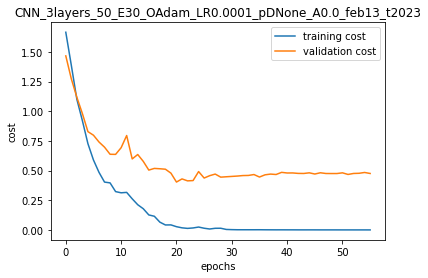

[TESTING] Test accuracy: 0.900000 --- Test cost: 0.469293
[0.110000 min, epoch 1] Train Cost: 9.430738 --- Validation Cost: 3.641318 --- Train accuracy: 0.056875 --- Validation accuracy: 0.145000
[0.170000 min, epoch 2] Train Cost: 3.407525 --- Validation Cost: 2.790448 --- Train accuracy: 0.171250 --- Validation accuracy: 0.265000
[0.230000 min, epoch 3] Train Cost: 2.577721 --- Validation Cost: 2.217558 --- Train accuracy: 0.306250 --- Validation accuracy: 0.330000
[0.290000 min, epoch 4] Train Cost: 2.163720 --- Validation Cost: 1.825784 --- Train accuracy: 0.405000 --- Validation accuracy: 0.490000
[0.340000 min, epoch 5] Train Cost: 1.772595 --- Validation Cost: 1.490641 --- Train accuracy: 0.518125 --- Validation accuracy: 0.580000
[0.400000 min, epoch 6] Train Cost: 1.448579 --- Validation Cost: 1.227480 --- Train accuracy: 0.604375 --- Validation accuracy: 0.625000
[0.460000 min, epoch 7] Train Cost: 1.201212 --- Validation Cost: 1.025020 --- Train accuracy: 0.670625 --- Valida

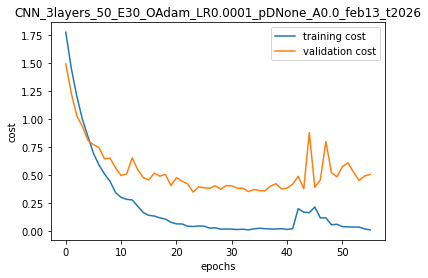

[TESTING] Test accuracy: 0.870000 --- Test cost: 0.662436
[0.100000 min, epoch 1] Train Cost: 9.300235 --- Validation Cost: 3.561749 --- Train accuracy: 0.062500 --- Validation accuracy: 0.125000
[0.160000 min, epoch 2] Train Cost: 3.212544 --- Validation Cost: 2.635525 --- Train accuracy: 0.175000 --- Validation accuracy: 0.275000
[0.230000 min, epoch 3] Train Cost: 2.582341 --- Validation Cost: 2.239853 --- Train accuracy: 0.315625 --- Validation accuracy: 0.400000
[0.280000 min, epoch 4] Train Cost: 2.163208 --- Validation Cost: 1.935416 --- Train accuracy: 0.423750 --- Validation accuracy: 0.445000
[0.330000 min, epoch 5] Train Cost: 1.804162 --- Validation Cost: 1.595306 --- Train accuracy: 0.504375 --- Validation accuracy: 0.525000
[0.380000 min, epoch 6] Train Cost: 1.524903 --- Validation Cost: 1.349993 --- Train accuracy: 0.590625 --- Validation accuracy: 0.615000
[0.450000 min, epoch 7] Train Cost: 1.246457 --- Validation Cost: 1.326504 --- Train accuracy: 0.660000 --- Valida

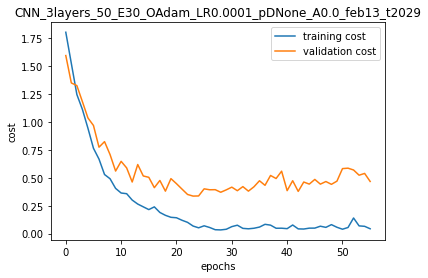

[TESTING] Test accuracy: 0.905000 --- Test cost: 0.553559
[0.110000 min, epoch 1] Train Cost: 8.642579 --- Validation Cost: 3.403086 --- Train accuracy: 0.059375 --- Validation accuracy: 0.125000
[0.160000 min, epoch 2] Train Cost: 3.156928 --- Validation Cost: 2.582958 --- Train accuracy: 0.188750 --- Validation accuracy: 0.250000
[0.230000 min, epoch 3] Train Cost: 2.532241 --- Validation Cost: 2.109270 --- Train accuracy: 0.306250 --- Validation accuracy: 0.375000
[0.280000 min, epoch 4] Train Cost: 2.158322 --- Validation Cost: 1.785082 --- Train accuracy: 0.392500 --- Validation accuracy: 0.500000
[0.340000 min, epoch 5] Train Cost: 1.782806 --- Validation Cost: 1.520404 --- Train accuracy: 0.500000 --- Validation accuracy: 0.570000
[0.390000 min, epoch 6] Train Cost: 1.477535 --- Validation Cost: 1.320723 --- Train accuracy: 0.592500 --- Validation accuracy: 0.640000
[0.450000 min, epoch 7] Train Cost: 1.235159 --- Validation Cost: 1.138368 --- Train accuracy: 0.655625 --- Valida

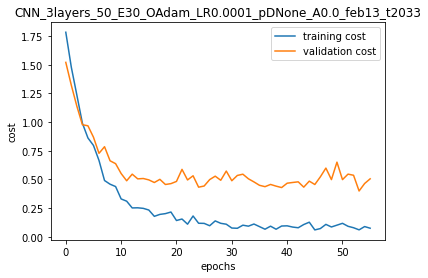

[TESTING] Test accuracy: 0.880000 --- Test cost: 0.534339
[0.130000 min, epoch 1] Train Cost: 8.623202 --- Validation Cost: 3.789114 --- Train accuracy: 0.070000 --- Validation accuracy: 0.085000
[0.180000 min, epoch 2] Train Cost: 3.256246 --- Validation Cost: 2.705142 --- Train accuracy: 0.193125 --- Validation accuracy: 0.255000
[0.240000 min, epoch 3] Train Cost: 2.673051 --- Validation Cost: 2.220124 --- Train accuracy: 0.298750 --- Validation accuracy: 0.390000
[0.310000 min, epoch 4] Train Cost: 2.202978 --- Validation Cost: 1.912699 --- Train accuracy: 0.393750 --- Validation accuracy: 0.495000
[0.360000 min, epoch 5] Train Cost: 1.898253 --- Validation Cost: 1.665717 --- Train accuracy: 0.470000 --- Validation accuracy: 0.580000
[0.410000 min, epoch 6] Train Cost: 1.574250 --- Validation Cost: 1.352933 --- Train accuracy: 0.563750 --- Validation accuracy: 0.640000
[0.470000 min, epoch 7] Train Cost: 1.308707 --- Validation Cost: 1.164127 --- Train accuracy: 0.645625 --- Valida

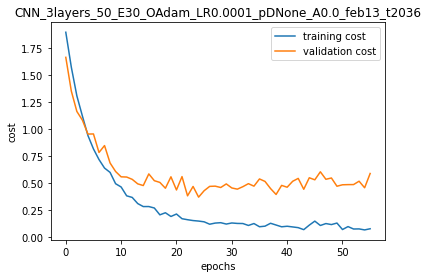

[TESTING] Test accuracy: 0.885000 --- Test cost: 0.438797
[0.130000 min, epoch 1] Train Cost: 8.373343 --- Validation Cost: 3.830913 --- Train accuracy: 0.082500 --- Validation accuracy: 0.180000
[0.180000 min, epoch 2] Train Cost: 3.371835 --- Validation Cost: 2.639484 --- Train accuracy: 0.175625 --- Validation accuracy: 0.330000
[0.230000 min, epoch 3] Train Cost: 2.598268 --- Validation Cost: 2.035520 --- Train accuracy: 0.306875 --- Validation accuracy: 0.450000
[0.300000 min, epoch 4] Train Cost: 2.088412 --- Validation Cost: 1.799000 --- Train accuracy: 0.418125 --- Validation accuracy: 0.470000
[0.360000 min, epoch 5] Train Cost: 1.714787 --- Validation Cost: 1.415487 --- Train accuracy: 0.525000 --- Validation accuracy: 0.570000
[0.410000 min, epoch 6] Train Cost: 1.473857 --- Validation Cost: 1.200603 --- Train accuracy: 0.595625 --- Validation accuracy: 0.680000
[0.460000 min, epoch 7] Train Cost: 1.216777 --- Validation Cost: 1.061501 --- Train accuracy: 0.658750 --- Valida

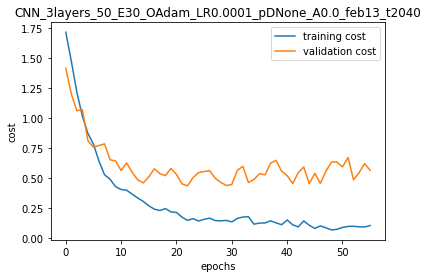

[TESTING] Test accuracy: 0.865000 --- Test cost: 0.592556
[0.120000 min, epoch 1] Train Cost: 10.111550 --- Validation Cost: 3.888906 --- Train accuracy: 0.048125 --- Validation accuracy: 0.100000
[0.180000 min, epoch 2] Train Cost: 3.396394 --- Validation Cost: 2.844600 --- Train accuracy: 0.158125 --- Validation accuracy: 0.195000
[0.230000 min, epoch 3] Train Cost: 2.696000 --- Validation Cost: 2.421402 --- Train accuracy: 0.267500 --- Validation accuracy: 0.315000
[0.290000 min, epoch 4] Train Cost: 2.331025 --- Validation Cost: 2.014520 --- Train accuracy: 0.356875 --- Validation accuracy: 0.395000
[0.350000 min, epoch 5] Train Cost: 2.005468 --- Validation Cost: 1.721131 --- Train accuracy: 0.446875 --- Validation accuracy: 0.465000
[0.410000 min, epoch 6] Train Cost: 1.739177 --- Validation Cost: 1.465013 --- Train accuracy: 0.515625 --- Validation accuracy: 0.600000
[0.460000 min, epoch 7] Train Cost: 1.554694 --- Validation Cost: 1.240758 --- Train accuracy: 0.575625 --- Valid

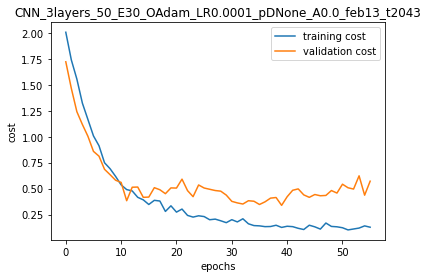

[TESTING] Test accuracy: 0.875000 --- Test cost: 0.527026
[0.110000 min, epoch 1] Train Cost: 12.290742 --- Validation Cost: 4.176621 --- Train accuracy: 0.040625 --- Validation accuracy: 0.095000
[0.180000 min, epoch 2] Train Cost: 3.436905 --- Validation Cost: 3.013474 --- Train accuracy: 0.151875 --- Validation accuracy: 0.195000
[0.240000 min, epoch 3] Train Cost: 2.605987 --- Validation Cost: 2.541314 --- Train accuracy: 0.315000 --- Validation accuracy: 0.335000
[0.300000 min, epoch 4] Train Cost: 2.099478 --- Validation Cost: 2.049237 --- Train accuracy: 0.435000 --- Validation accuracy: 0.470000
[0.360000 min, epoch 5] Train Cost: 1.708182 --- Validation Cost: 1.714031 --- Train accuracy: 0.528125 --- Validation accuracy: 0.550000
[0.430000 min, epoch 6] Train Cost: 1.386323 --- Validation Cost: 1.455234 --- Train accuracy: 0.623125 --- Validation accuracy: 0.650000
[0.490000 min, epoch 7] Train Cost: 1.071909 --- Validation Cost: 1.202149 --- Train accuracy: 0.700000 --- Valid

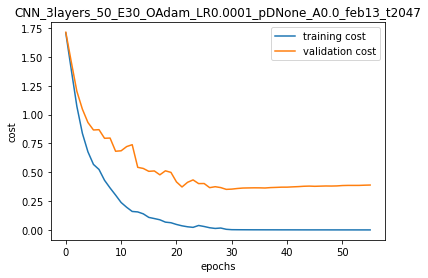

[TESTING] Test accuracy: 0.900000 --- Test cost: 0.489295
[0.110000 min, epoch 1] Train Cost: 9.692284 --- Validation Cost: 4.015792 --- Train accuracy: 0.058125 --- Validation accuracy: 0.120000
[0.170000 min, epoch 2] Train Cost: 3.348541 --- Validation Cost: 2.897264 --- Train accuracy: 0.158750 --- Validation accuracy: 0.230000
[0.240000 min, epoch 3] Train Cost: 2.740056 --- Validation Cost: 2.472307 --- Train accuracy: 0.278750 --- Validation accuracy: 0.335000
[0.300000 min, epoch 4] Train Cost: 2.253097 --- Validation Cost: 2.221563 --- Train accuracy: 0.382500 --- Validation accuracy: 0.390000
[0.350000 min, epoch 5] Train Cost: 1.928560 --- Validation Cost: 1.820122 --- Train accuracy: 0.459375 --- Validation accuracy: 0.505000
[0.420000 min, epoch 6] Train Cost: 1.601607 --- Validation Cost: 1.528880 --- Train accuracy: 0.539375 --- Validation accuracy: 0.600000
[0.480000 min, epoch 7] Train Cost: 1.380519 --- Validation Cost: 1.373388 --- Train accuracy: 0.608750 --- Valida

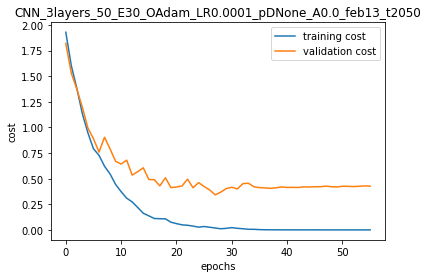

[TESTING] Test accuracy: 0.895000 --- Test cost: 0.502968
[0.120000 min, epoch 1] Train Cost: 9.849526 --- Validation Cost: 3.677690 --- Train accuracy: 0.069375 --- Validation accuracy: 0.115000
[0.180000 min, epoch 2] Train Cost: 3.276210 --- Validation Cost: 2.763750 --- Train accuracy: 0.160000 --- Validation accuracy: 0.240000
[0.230000 min, epoch 3] Train Cost: 2.664529 --- Validation Cost: 2.326039 --- Train accuracy: 0.280625 --- Validation accuracy: 0.325000
[0.290000 min, epoch 4] Train Cost: 2.264179 --- Validation Cost: 1.956719 --- Train accuracy: 0.381875 --- Validation accuracy: 0.465000
[0.360000 min, epoch 5] Train Cost: 1.868221 --- Validation Cost: 1.687570 --- Train accuracy: 0.481875 --- Validation accuracy: 0.525000
[0.410000 min, epoch 6] Train Cost: 1.622636 --- Validation Cost: 1.371094 --- Train accuracy: 0.538125 --- Validation accuracy: 0.575000
[0.470000 min, epoch 7] Train Cost: 1.378632 --- Validation Cost: 1.196926 --- Train accuracy: 0.605625 --- Valida

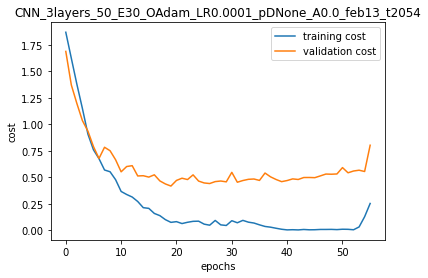

[TESTING] Test accuracy: 0.825000 --- Test cost: 0.906740
[0.120000 min, epoch 1] Train Cost: 10.371050 --- Validation Cost: 3.740848 --- Train accuracy: 0.049375 --- Validation accuracy: 0.135000
[0.170000 min, epoch 2] Train Cost: 3.421206 --- Validation Cost: 2.925814 --- Train accuracy: 0.146875 --- Validation accuracy: 0.270000
[0.230000 min, epoch 3] Train Cost: 2.784218 --- Validation Cost: 2.484956 --- Train accuracy: 0.256875 --- Validation accuracy: 0.305000
[0.280000 min, epoch 4] Train Cost: 2.436035 --- Validation Cost: 2.257658 --- Train accuracy: 0.328750 --- Validation accuracy: 0.385000
[0.350000 min, epoch 5] Train Cost: 2.113621 --- Validation Cost: 1.920787 --- Train accuracy: 0.423750 --- Validation accuracy: 0.455000
[0.410000 min, epoch 6] Train Cost: 1.855039 --- Validation Cost: 1.700161 --- Train accuracy: 0.489375 --- Validation accuracy: 0.485000
[0.470000 min, epoch 7] Train Cost: 1.614992 --- Validation Cost: 1.526513 --- Train accuracy: 0.525000 --- Valid

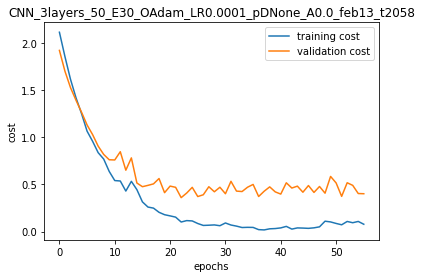

[TESTING] Test accuracy: 0.905000 --- Test cost: 0.512253
[0.120000 min, epoch 1] Train Cost: 10.124390 --- Validation Cost: 4.409692 --- Train accuracy: 0.046250 --- Validation accuracy: 0.160000
[0.170000 min, epoch 2] Train Cost: 3.451268 --- Validation Cost: 2.844546 --- Train accuracy: 0.171250 --- Validation accuracy: 0.315000
[0.230000 min, epoch 3] Train Cost: 2.726528 --- Validation Cost: 2.547776 --- Train accuracy: 0.278750 --- Validation accuracy: 0.325000
[0.290000 min, epoch 4] Train Cost: 2.321441 --- Validation Cost: 2.188315 --- Train accuracy: 0.355000 --- Validation accuracy: 0.385000
[0.350000 min, epoch 5] Train Cost: 1.951377 --- Validation Cost: 1.825440 --- Train accuracy: 0.452500 --- Validation accuracy: 0.455000
[0.410000 min, epoch 6] Train Cost: 1.646025 --- Validation Cost: 1.718712 --- Train accuracy: 0.555625 --- Validation accuracy: 0.510000
[0.460000 min, epoch 7] Train Cost: 1.421350 --- Validation Cost: 1.504326 --- Train accuracy: 0.606250 --- Valid

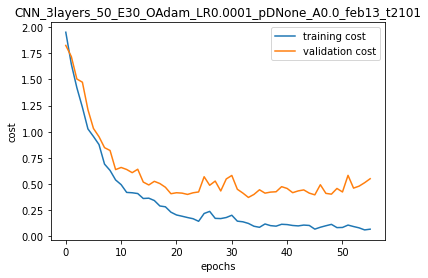

[TESTING] Test accuracy: 0.885000 --- Test cost: 0.672670
[0.120000 min, epoch 1] Train Cost: 10.020132 --- Validation Cost: 4.005147 --- Train accuracy: 0.051875 --- Validation accuracy: 0.095000
[0.180000 min, epoch 2] Train Cost: 3.457059 --- Validation Cost: 2.911065 --- Train accuracy: 0.152500 --- Validation accuracy: 0.235000
[0.230000 min, epoch 3] Train Cost: 2.859236 --- Validation Cost: 2.600379 --- Train accuracy: 0.265625 --- Validation accuracy: 0.265000
[0.300000 min, epoch 4] Train Cost: 2.525008 --- Validation Cost: 2.173055 --- Train accuracy: 0.311250 --- Validation accuracy: 0.390000
[0.360000 min, epoch 5] Train Cost: 2.150954 --- Validation Cost: 2.047857 --- Train accuracy: 0.411875 --- Validation accuracy: 0.400000
[0.410000 min, epoch 6] Train Cost: 1.933260 --- Validation Cost: 1.778007 --- Train accuracy: 0.464375 --- Validation accuracy: 0.500000
[0.470000 min, epoch 7] Train Cost: 1.690687 --- Validation Cost: 1.522715 --- Train accuracy: 0.531250 --- Valid

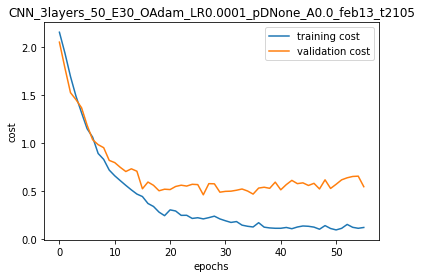

[TESTING] Test accuracy: 0.885000 --- Test cost: 0.457072
[0.120000 min, epoch 1] Train Cost: 10.153534 --- Validation Cost: 3.980254 --- Train accuracy: 0.045625 --- Validation accuracy: 0.110000
[0.180000 min, epoch 2] Train Cost: 3.698672 --- Validation Cost: 2.987845 --- Train accuracy: 0.126250 --- Validation accuracy: 0.200000
[0.230000 min, epoch 3] Train Cost: 3.030338 --- Validation Cost: 2.434485 --- Train accuracy: 0.226875 --- Validation accuracy: 0.330000
[0.300000 min, epoch 4] Train Cost: 2.642345 --- Validation Cost: 2.136619 --- Train accuracy: 0.287500 --- Validation accuracy: 0.435000
[0.360000 min, epoch 5] Train Cost: 2.302407 --- Validation Cost: 1.916253 --- Train accuracy: 0.390000 --- Validation accuracy: 0.490000
[0.410000 min, epoch 6] Train Cost: 2.025705 --- Validation Cost: 1.663213 --- Train accuracy: 0.425000 --- Validation accuracy: 0.580000
[0.470000 min, epoch 7] Train Cost: 1.821903 --- Validation Cost: 1.460106 --- Train accuracy: 0.495625 --- Valid

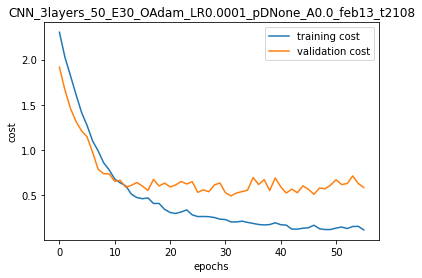

[TESTING] Test accuracy: 0.880000 --- Test cost: 0.564198
[0.120000 min, epoch 1] Train Cost: 10.900965 --- Validation Cost: 4.188781 --- Train accuracy: 0.049375 --- Validation accuracy: 0.105000
[0.180000 min, epoch 2] Train Cost: 3.519932 --- Validation Cost: 2.874410 --- Train accuracy: 0.143125 --- Validation accuracy: 0.230000
[0.240000 min, epoch 3] Train Cost: 2.931670 --- Validation Cost: 2.407941 --- Train accuracy: 0.240000 --- Validation accuracy: 0.360000
[0.300000 min, epoch 4] Train Cost: 2.534467 --- Validation Cost: 2.240857 --- Train accuracy: 0.315625 --- Validation accuracy: 0.375000
[0.360000 min, epoch 5] Train Cost: 2.341860 --- Validation Cost: 1.922491 --- Train accuracy: 0.365000 --- Validation accuracy: 0.470000
[0.410000 min, epoch 6] Train Cost: 2.079141 --- Validation Cost: 1.732771 --- Train accuracy: 0.413750 --- Validation accuracy: 0.515000
[0.480000 min, epoch 7] Train Cost: 1.871993 --- Validation Cost: 1.659620 --- Train accuracy: 0.479375 --- Valid

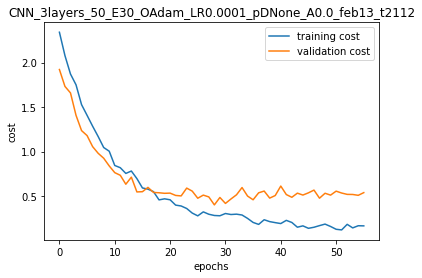

[TESTING] Test accuracy: 0.885000 --- Test cost: 0.518278
[0.110000 min, epoch 1] Train Cost: 12.782489 --- Validation Cost: 4.159447 --- Train accuracy: 0.056875 --- Validation accuracy: 0.125000
[0.170000 min, epoch 2] Train Cost: 3.326386 --- Validation Cost: 2.938665 --- Train accuracy: 0.175000 --- Validation accuracy: 0.215000
[0.230000 min, epoch 3] Train Cost: 2.550502 --- Validation Cost: 2.460288 --- Train accuracy: 0.316875 --- Validation accuracy: 0.290000
[0.290000 min, epoch 4] Train Cost: 2.098392 --- Validation Cost: 2.172919 --- Train accuracy: 0.425000 --- Validation accuracy: 0.355000
[0.340000 min, epoch 5] Train Cost: 1.737193 --- Validation Cost: 1.841215 --- Train accuracy: 0.523750 --- Validation accuracy: 0.460000
[0.410000 min, epoch 6] Train Cost: 1.458323 --- Validation Cost: 1.496150 --- Train accuracy: 0.601875 --- Validation accuracy: 0.540000
[0.460000 min, epoch 7] Train Cost: 1.175243 --- Validation Cost: 1.279379 --- Train accuracy: 0.694375 --- Valid

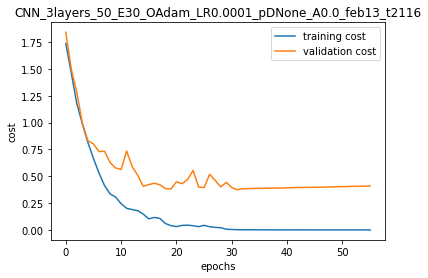

[TESTING] Test accuracy: 0.885000 --- Test cost: 0.434698
[0.110000 min, epoch 1] Train Cost: 10.515045 --- Validation Cost: 3.828993 --- Train accuracy: 0.053125 --- Validation accuracy: 0.095000
[0.170000 min, epoch 2] Train Cost: 3.291607 --- Validation Cost: 2.743634 --- Train accuracy: 0.180625 --- Validation accuracy: 0.235000
[0.240000 min, epoch 3] Train Cost: 2.538391 --- Validation Cost: 2.249239 --- Train accuracy: 0.316250 --- Validation accuracy: 0.360000
[0.290000 min, epoch 4] Train Cost: 2.135803 --- Validation Cost: 1.906004 --- Train accuracy: 0.406875 --- Validation accuracy: 0.425000
[0.350000 min, epoch 5] Train Cost: 1.738760 --- Validation Cost: 1.706015 --- Train accuracy: 0.511875 --- Validation accuracy: 0.500000
[0.410000 min, epoch 6] Train Cost: 1.487273 --- Validation Cost: 1.460200 --- Train accuracy: 0.580625 --- Validation accuracy: 0.560000
[0.470000 min, epoch 7] Train Cost: 1.196000 --- Validation Cost: 1.316255 --- Train accuracy: 0.661875 --- Valid

In [ ]:
# Parameters
params = {'data_type': 'mfcc',
          'batch_size': 50,
          'epochs': 30,
          'augment_prob': 0.,
          'p_dropout': None,
          'optimizer_name': 'Adam',
          'lr': 0.0001}

import itertools

grid_params = {
          'augment_prob': [0.4,0.8],
          'p_dropout': [0.2,0.5],
          'n_freq': [0,1],
          'n_time': [0,1],
          'noise_level': [0.02, 0.04]
          }

param_combinations = list(itertools.product(*grid_params.values()))
transforms = augmentation_2d
validation_generator = DataGenerator(val_df, data_type=params["data_type"], batch_size=params["batch_size"], transforms=None, augment_prob=0., shuffle=True)
testing_generator = DataGenerator(test_df, data_type=params["data_type"], batch_size=params["batch_size"], transforms=None, augment_prob=0., shuffle=True)

for gparams in param_combinations:
    augment_prob, p_dropout, n_freq, n_time, noise_level = gparams
    training_generator = DataGenerator(train_df, data_type=params["data_type"], batch_size=params["batch_size"], transforms=transforms, aug_par=[n_freq, n_time, noise_level], augment_prob=augment_prob, shuffle=True)
    F = 128
    residual = True
    model = CNN(p_dropout=p_dropout,F=F,n=3,residual=residual)

    total_params = 0

    timestamp = time.strftime("feb%d_t%H%M", time.gmtime())
    model_name = f"{model.description}_{params['batch_size']}_E{params['epochs']}_O{params['optimizer_name']}_LR{params['lr']}_pD{params['p_dropout']}_A{params['augment_prob']}_{timestamp}"
    best_val_accuracy, best_train_accuracy, best_epoch, t = train_model(model, training_generator, validation_generator)
    test_accuracy, test_cost = test_model(model, testing_generator)

    # save the training hyperparameters and results info 
    current_time = time.strftime("%m-%d %H:%M")
    with open('./drive/MyDrive/HDA_results/HDA_log.csv', mode='a') as file:
        writer = csv.writer(file)
        writer.writerow([current_time, model.description, params['data_type'], 
                        params['batch_size'], params['epochs'], 
                        params['augment_prob'], params['p_dropout'],
                        params['optimizer_name'], params['lr'], 
                        np.round(best_train_accuracy, 4), 
                        np.round(best_val_accuracy, 4), 
                        np.round(test_accuracy, 4), best_epoch, total_params, F, residual, t, augment_prob, p_dropout, n_freq, n_time, noise_level])